# Model Performance


## Prerequisites
Install python packages

In [1]:
%%capture
%pip install pandas pydicom pydicom-seg scikit-learn seaborn segmentationmetrics requests

In [2]:
import warnings

warnings.filterwarnings("ignore")

from pathlib import Path
import requests
import zipfile
import subprocess
import io
import numpy as np
import pandas as pd
import scipy.stats as stats
import pydicom
import pydicom_seg
import SimpleITK as sitk
import matplotlib.pyplot as plt
import segmentationmetrics as sm
from segmentationmetrics.surface_distance import compute_surface_dice_at_tolerance
import seaborn as sns
from tqdm.auto import tqdm

sns.set_theme(style="whitegrid")
%matplotlib inline


## Download the segmentation results from zenodo

In [3]:
qa_dir = Path("qa-results")

In [4]:
def download_inference(
    extract_dir="qa-results", record="12734644", filename="lung2-ct.zip"
):
    url = (f"https://zenodo.org/record/{record}/files/{filename}")
    # download the zip file and extract it
    r = requests.get(url)
    z = zipfile.ZipFile(io.BytesIO(r.content))
    z.extractall(extract_dir)


if not qa_dir.exists() or not (qa_dir / "ai-segmentations-dcm").exists():
    download_inference(qa_dir)

In [5]:
def load_dcm_seg(seg_path: Path, label=1):
    reader = pydicom_seg.SegmentReader()
    dcm = pydicom.dcmread(str(seg_path))
    seg = reader.read(dcm)
    if label in seg._segment_data:
        result = sitk.GetImageFromArray(seg._segment_data[label])
    else:
        # Create a zero-valued image with the same dimensions, origin, spacing, and direction
        zero_array = np.zeros_like(seg._segment_data[1])
        result = sitk.GetImageFromArray(zero_array)
    result = sitk.Cast(result, sitk.sitkUInt8)
    result.SetOrigin(seg.origin)
    result.SetSpacing(seg.spacing)
    result.SetDirection(seg.direction.flatten())
    result = sitk.Cast(result, sitk.sitkUInt8)
    return result


def load_nii_seg(seg_path: Path, label=1):
    img = sitk.ReadImage(str(seg_path))
    if label==1:
        img = sitk.Cast(img >= label, sitk.sitkUInt8)
    else:
        img = sitk.Cast(img == label, sitk.sitkUInt8)
    return img


def load_seg(seg_path: Path, label=1):
    if seg_path.suffix == ".dcm":
        return load_dcm_seg(seg_path, label)
    else:
        return load_nii_seg(seg_path, label)


def resize_label(img: sitk.Image, ref_img: sitk.Image, interp=sitk.sitkNearestNeighbor):
    resampler = sitk.ResampleImageFilter()
    resampler.SetReferenceImage(ref_img)
    resampler.SetInterpolator(interp)
    resampler.SetDefaultPixelValue(0)
    resampled_img = resampler.Execute(img)
    return resampled_img


def calc_metrics_for_label(ai_seg_file, qa_seg_file, fname, label_value=1, version="aimiv2", label_suffix=""):
    ai_img = load_seg(ai_seg_file, label_value)
    qa_img = load_seg(qa_seg_file, label_value)
    qa_img = resize_label(qa_img, ai_img)  # match the size of the ai_img
    ai_arr = sitk.GetArrayFromImage(ai_img)
    qa_arr = sitk.GetArrayFromImage(qa_img)
    spacing = ai_img.GetSpacing()[::-1]  # numpy is reversed dimensions from sitk

    qa_img = resize_label(qa_img, ai_img)  # match the size of the ai_img
    m = sm.SegmentationMetrics(ai_arr, qa_arr, spacing)

    metrics = {
        "dice": m.dice,
        "hausdorff_distance_95": m.hausdorff_distance,
        "mean_surface_distance": m.mean_surface_distance,
        "mean_surface_distance_tol_7": compute_surface_dice_at_tolerance(
            m._surface_dist, 7
        ),
        "SeriesInstanceUID": fname,  # from medical segmentation decathlon
        "label": label_value,
        "version": version,
    }
    if label_suffix:
        metrics = {f"{k}_{label_suffix}": v for k, v in metrics.items()}
    return metrics

### Calculating metrics

In [6]:
def process_segmentation_metrics(
    qa_results_csv: Path,
    qa_segmentations_path: Path,
    aimiv2_path: Path,
    aimiv1_path: Path = None,
):
    """
    Processes segmentation metrics and aggregates results from provided paths.

    Args:
    qa_results_csv (Path): Path to the QA results CSV file.
    qa_segmentations_path (Path): Path to the QA segmentations directory.
    aimiv2_path (Path): Path to the AIMIv2 segmentations directory.
    aimiv1_path (Path, optional): Path to the AIMIv1 segmentations directory. Defaults to None.

    Returns:
    pd.DataFrame: Aggregated results.
    """
    aimiv1_metrics, aimiv2_metrics = [], []

    # Load the CSV file
    df = pd.read_csv(qa_results_csv.resolve())

    aimiv1 = aimiv1_path.resolve() if aimiv1_path else None
    aimiv2 = aimiv2_path.resolve()
    qapath = qa_segmentations_path.resolve()

    for file in qapath.glob("*dcm"):
        fname = Path(file.stem).stem.split("qa-")[-1]
        aimiv2_fname = aimiv2 / f"ai-{fname}.seg.dcm"
        qa_seg_file = qapath / f"qa-{fname}.seg.dcm"

        assert aimiv2_fname.exists()
        assert qa_seg_file.exists()

        if aimiv1:
            aimiv1_fname = aimiv1 / f"aimiv1-{fname}.nii.gz"
            if aimiv1_fname.exists():
                aimiv1_metrics.append(
                    calc_metrics_for_label(
                        aimiv1_fname,
                        qa_seg_file,
                        fname,
                        version="aimiv1",
                        label_value=2,
                    )
                )
                aimiv1_metrics.append(
                    calc_metrics_for_label(
                        aimiv1_fname,
                        qa_seg_file,
                        fname,
                        version="aimiv1",
                        label_value=1,
                    )
                )

        aimiv2_metrics.append(
            calc_metrics_for_label(aimiv2_fname, qa_seg_file, fname, label_value=2)
        )
        aimiv2_metrics.append(
            calc_metrics_for_label(aimiv2_fname, qa_seg_file, fname, label_value=1)
        )

    if aimiv1_metrics:
        aimiv1_df = pd.DataFrame(aimiv1_metrics)
        aimiv1_df = aimiv1_df.add_prefix("aimiv1_")
        aimiv1_df = aimiv1_df.rename(
            columns={"aimiv1_SeriesInstanceUID": "SeriesInstanceUID"}
        )
    else:
        aimiv1_df = pd.DataFrame()

    aimiv2_df = pd.DataFrame(aimiv2_metrics)
    aimiv2_df = aimiv2_df.add_prefix("aimiv2_")
    aimiv2_df = aimiv2_df.rename(
        columns={"aimiv2_SeriesInstanceUID": "SeriesInstanceUID"}
    )

    if not aimiv1_df.empty:
        combined_df = pd.merge(
            aimiv1_df, aimiv2_df, on="SeriesInstanceUID", how="outer"
        )
    else:
        combined_df = aimiv2_df.copy()

    combined_df = combined_df.replace([np.inf, -np.inf], np.nan).dropna()

    aimiv1_cols = [
        "SeriesInstanceUID",
        "aimiv1_label",
        "aimiv1_dice",
        "aimiv1_hausdorff_distance_95",
        "aimiv1_mean_surface_distance",
        "aimiv1_mean_surface_distance_tol_7",
        "aimiv1_version",
    ]
    aimiv2_cols = [
        "SeriesInstanceUID",
        "aimiv2_label",
        "aimiv2_dice",
        "aimiv2_hausdorff_distance_95",
        "aimiv2_mean_surface_distance",
        "aimiv2_mean_surface_distance_tol_7",
        "aimiv2_version",
    ]

    df1 = (
        combined_df[aimiv1_cols].rename(columns=lambda x: x.replace("aimiv1_", ""))
        if not aimiv1_df.empty
        else pd.DataFrame()
    )
    df2 = combined_df[aimiv2_cols].rename(columns=lambda x: x.replace("aimiv2_", ""))

    combined_df = pd.concat([df1, df2]) if not df1.empty else df2

    aggregated_df = (
        combined_df.groupby(["label", "version"])
        .agg(
            {
                "dice": ["mean", "std"],
                "hausdorff_distance_95": ["mean", "std"],
                "mean_surface_distance": ["mean", "std"],
                "mean_surface_distance_tol_7": ["mean", "std"],
            }
        )
        .round(2)
    )

    return aggregated_df, aimiv1_df, aimiv2_df


qa_results_csv = Path("qa-results/qa-results.csv")
qa_segmentations_path = Path("qa-results/qa-segmentations-dcm")
aimiv2_path = Path("qa-results/ai-segmentations-dcm")

aggregated_df, aimiv1_df, aimiv2_df = process_segmentation_metrics(
    qa_results_csv, qa_segmentations_path, aimiv2_path
)


### Plotting the model performance

In [ ]:
aggregated_df

dice       hausdorff_distance_95        mean_surface_distance  \
               mean   std                  mean    std                  mean   
label version                                                                  
1     aimiv1   0.99  0.00                  0.80   0.97                  0.18   
      aimiv2   1.00  0.00                  0.07   0.68                  0.02   
2     aimiv1   0.58  0.31                 99.74  63.34                 21.77   
      aimiv2   0.76  0.28                 65.36  65.12                 10.87   

                     mean_surface_distance_tol_7        
                 std                        mean   std  
label version                                           
1     aimiv1    0.12                        1.00  0.01  
      aimiv2    0.08                        1.00  0.00  
2     aimiv1   23.92                        0.67  0.29  
      aimiv2   14.67                        0.82  0.22

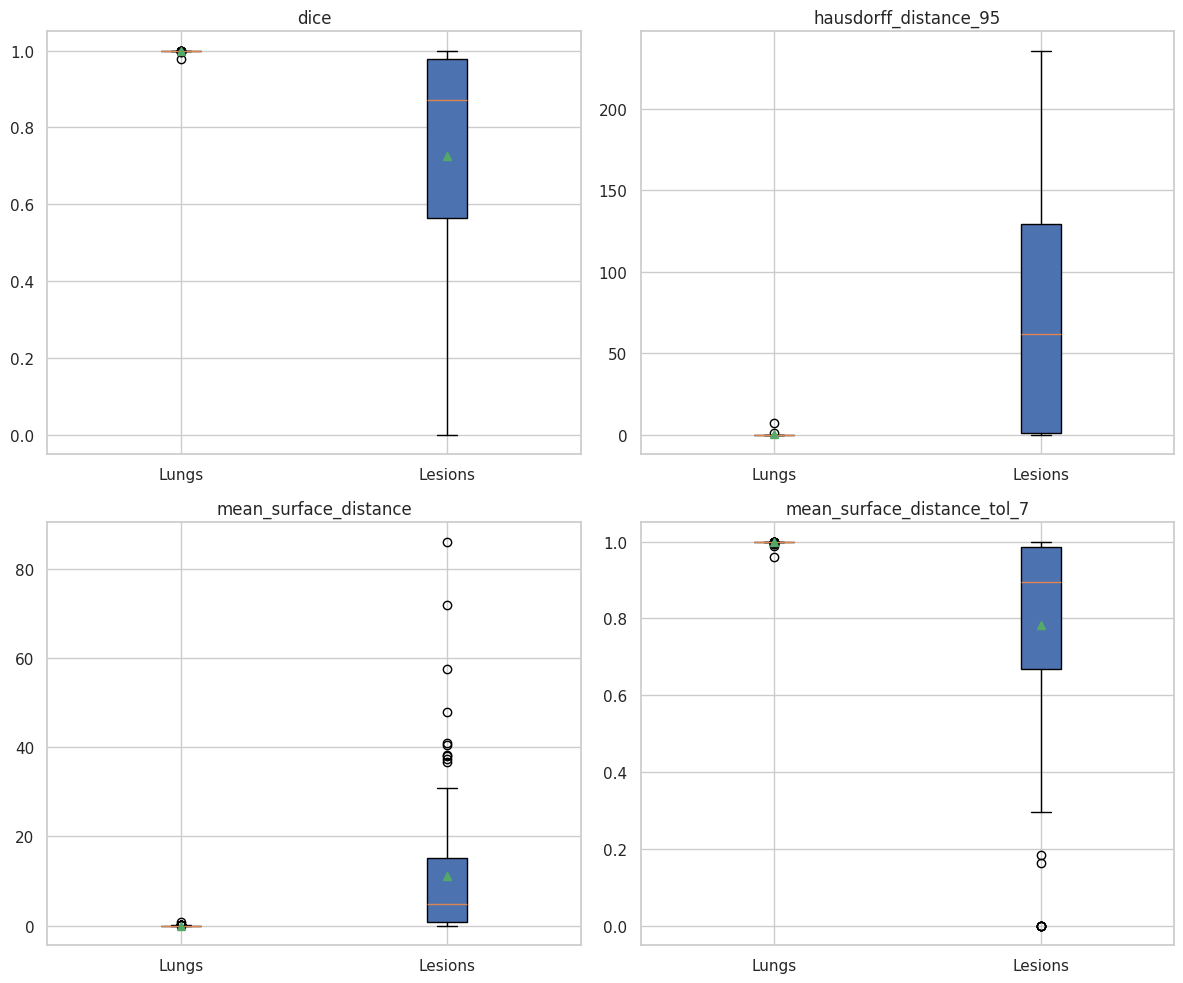

In [ ]:
# Check if aimiv2_df is not empty
if not aimiv2_df.empty:
    # Separate data for label1 (lung) and label2 (lesion) for aimiv2
    aimiv2_label1_df = aimiv2_df[aimiv2_df["aimiv2_label"] == 1]
    aimiv2_label2_df = aimiv2_df[aimiv2_df["aimiv2_label"] == 2]

    # Create a figure and axis for subplots
    fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))

    # List of metrics to plot
    metrics = [
        "aimiv2_dice",
        "aimiv2_hausdorff_distance_95",
        "aimiv2_mean_surface_distance",
        "aimiv2_mean_surface_distance_tol_7",
    ]

    # Plot each metric
    for i, metric in enumerate(metrics):
        row = i // 2
        col = i % 2
        ax = axs[row, col]

        # Extract data for current metric
        label1_data = aimiv2_label1_df[metric]
        label2_data = aimiv2_label2_df[metric]

        # Check if both label1_data and label2_data have values and are not empty
        if not label1_data.empty and not label2_data.empty:
            # Convert data to numeric if necessary
            label1_data = pd.to_numeric(label1_data, errors="coerce")
            label2_data = pd.to_numeric(label2_data, errors="coerce")

            # Drop NaN values if any (optional)
            label1_data = label1_data.dropna()
            label2_data = label2_data.dropna()

            # Check if after dropping NaN, there's still data
            if not label1_data.empty and not label2_data.empty:
                # Create boxplots side by side
                ax.boxplot(
                    [label1_data, label2_data], patch_artist=True, showmeans=True
                )
                ax.set_title(f"{metric.split('aimiv2_')[-1]}")
                ax.set_xticklabels(
                    ["Lungs", "Lesions"]
                )  # Update x-axis labels to "Lesions"
            else:
                # Handle case where data might be dropped to empty
                print(f"No valid data available for {metric} after cleaning.")
        else:
            # If either label1_data or label2_data is empty, handle accordingly
            print(
                f"No data available for {metric} in either label1 (Lungs) or label2 (Lesions)."
            )

    # Adjust layout
    plt.tight_layout()
    plt.show()
else:
    print("aimiv2_df is empty. No plots to display.")